In [294]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import sep
from astropy.io import fits 
from astropy import coordinates, table
from astropy.visualization import make_lupton_rgb

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfstats import imstats

from carpenter import pixels, conventions
from pieridae.starbursts import sample

In [3]:
catalog, masks = sample.load_sample(filename='../../local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet')

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.5 seconds.
Computed internal extinction corrections in 0.6 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [348]:
targetid = 'M3373376440807468772'
target = conventions.produce_merianobjectname(*catalog.loc[targetid, ['RA','DEC']].values)
#target = 'J095618.67+030835.28'
#target = 'J101950.14+042441.99' # no substructure
#target = 'J100615.79+032656.01' # messy spiral
#target = 'J103511.49+030802.87' # no substructure, elongated body
target = 'J093020.88+032019.66' # merging pair
#target = 'J121004.84+015540.11' # another stream
targetid = conventions.merianobjectname_to_catalogname(target, catalog)
print(target)

J093020.88+032019.66


In [349]:
dirname = '../local_data/test_cutout/'
bbmb = pixels.BBMBImage()
for band in ['g', 'n540', 'r', 'n708', 'i', 'z']:
    if band in ['n540', 'n708']:
        cutout = f'{dirname}/merian/{target}_{band.upper()}_merim.fits'
        psf = f'{dirname}/merian/{target}_{band.upper()}_merpsf.fits'
    else:
        cutout = f'{dirname}/hsc/{target}_HSC-{band}.fits'
        psf = f'{dirname}/hsc/{target}_HSC-{band}_psf.fits'

    if not os.path.exists(cutout) or not os.path.exists(psf):
        print(f"Missing files for {targetid} band {band}, skipping target...")
            
    bbmb.add_band(
        band,
        coordinates.SkyCoord(catalog.loc[targetid, 'RA'], catalog.loc[targetid, 'DEC'], unit='deg'),
        size=150,
        image=cutout,
        var=cutout,
        psf=psf,
        image_ext=1,
        var_ext=3,
        psf_ext=0
    )

In [368]:
source_cat,sources = sep.extract( bbmb.image['i'].byteswap().newbyteorder(), 
                                 3, 
                                 var=bbmb.var['i'].byteswap().newbyteorder(), 
                                 segmentation_map=True)
central_source = sources[sources.shape[0]//2, sources.shape[1]//2]
csource = np.where(sources==central_source, 1, 0)
sources = np.where(sources==central_source, 0, sources)

In [369]:
use_gen2 = True
vm = np.random.normal(0., bbmb.var['i']**0.5)
wt = imstats.starlet_transform(np.where(sources>0, 0., bbmb.image['i']), gen2=use_gen2)
segmap_l = []
im_recon = []
for ix in range(0,len(wt)):
    err_samples = [
        np.std(abs(wt[ix])[:25,-25:]),
        np.std(abs(wt[ix])[-25:,-25:]),
        np.std(abs(wt[ix])[:25,:25]),
        np.std(abs(wt[ix])[-25,:25])
    ]
    
    _,segmap = sep.extract ( abs(wt[ix]), 10., err=np.median(err_samples), segmentation_map=True, deblend_cont=1.)
    sidx = segmap[segmap.shape[0]//2,segmap.shape[0]//2]
    #print(sidx)
    segmap_l.append(segmap)
    im_recon.append (np.where(segmap==sidx, wt[ix], 0.))
    #np.where((segmap==sidx)|((segmap>0)&(sources>0))
im_recon = imstats.inverse_starlet_transform(im_recon, gen2=use_gen2)
hf_image = bbmb.image['i'] - im_recon
hf_image = hf_image - ndimage.median_filter(hf_image, size=20)
hf_image = np.where(sources>0, vm, hf_image)

err_samples = [
    np.std(hf_image[:25,-25:]),
    np.std(hf_image[-25:,-25:]),
    np.std(hf_image[:25,:25]),
    np.std(hf_image[-25,:25])
]

_,lsb_features = sep.extract(hf_image, 1, err=np.median(err_samples), deblend_cont=1., segmentation_map=True )
minarea = np.pi*(bbmb.measure_psfsizes()[0][np.in1d(bbmb.bands, 'i')])**2
feature_cat,hsb_features = sep.extract(hf_image, 2, err=np.median(err_samples), segmentation_map=True, minarea=minarea )
ellips = table.Table(feature_cat)['b']/table.Table(feature_cat)['a']
for hidx in np.unique(hsb_features)[1:]:
    if ellips[hidx-1] > 0.6:
        hsb_features[hsb_features == hidx] = 0

features = np.zeros_like(hsb_features)
areas = ndimage.sum(np.where(features>0,1,0),labels=features, index=np.unique(features)[1:])

for ix in np.unique(lsb_features)[1:]:
    if (hsb_features[lsb_features==ix]>0).any():
        features[lsb_features==ix] = 1
features = ndimage.label(features)[0]
rmag = -2.5*np.log10(ndimage.sum_labels(bbmb.image['i'], features, np.unique(features)[1:])) + 27.


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_93763/555880327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feature_cat,hsb_features = sep.extract(hf_image, 2, err=np.median(err_samples), segmentation_map=True, minarea=minarea )


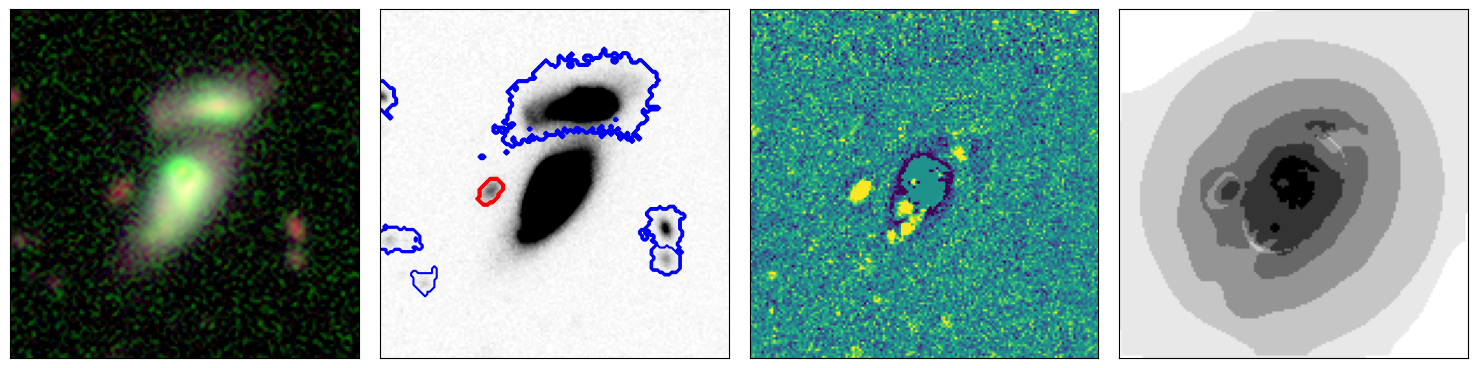

In [370]:
fig, axarr = plt.subplots(1,4,figsize=(15,4))
ek.imshow(hf_image, q=0.01,ax=axarr[2], cmap='viridis',)# qlow=sampling.get_quantile_of_value(hf_image.flatten(), 0.))
ek.contour(features,ax=axarr[1], colors='r')
ek.contour(sources, ax=axarr[1], colors='b')
ek.imshow(make_lupton_rgb(bbmb.image['i'],bbmb.image['n708'],bbmb.image['r'], stretch=1, Q=7), axarr[0])
ek.imshow(bbmb.image['i'], q=0.05,ax=axarr[1], cmap='Greys')
axarr[3].imshow(np.sum(np.array(segmap_l).astype(bool).astype(int),axis=0), origin='lower', cmap='Greys')

for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout ()

In [335]:
dd = np.load(
    '/Users/kadofong/work/projects/merian/pixel_excess/local_data/pieridae_output/starlet_qa/M3123725728651166755/M3123725728651166755_results.npy',
    allow_pickle=True
)

15.0


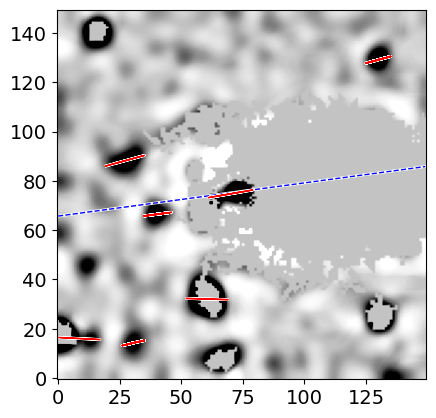

In [283]:
ridge_stats = []
for feat in np.arange(1,np.max(features)+1):
    rout = fit.fit_ridgeline_image( hf_image, features==feat, order=1, return_stats=True)
    # coefficients, predict_func, fitted_coordinates,stats = rout
    ridge_stats.append(rout)
csersic, cim = fit.fit_sersic_2d(np.where(csource, bbmb.image['i'],0.))

xs = np.arange(cim.shape[1])
ys = np.arctan(csersic.theta.value)*(xs-csersic.x_0.value) + csersic.y_0.value

ek.imshow(hf_image, cmap='Greys')
#ek.outlined_plot(central_fitted_coordinates['x'], central_predict_func(central_fitted_coordinates['x']), color='b', lw=1)
#ek.contour(cim, colors='b')
ek.outlined_plot(xs, ys, color='b', ls='--', lw=1)

for rout in ridge_stats:
    coefficients, predict_func, fitted_coordinates,stats = rout
    ek.outlined_plot(fitted_coordinates['x'], predict_func(fitted_coordinates['x']), color='r', lw=1)


In [290]:
from astropy import cosmology
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [291]:
rmag = -2.5*np.log10(csersic.luminosity) + 27.
rmag_catalog = -2.5*np.log10(catalog.loc[targetid,'r_cModelFlux_Merian']*1e-9/3631.)

logmstar_adjusted = 0.4*(rmag_catalog - rmag) + catalog.loc[targetid,'logmass']

In [292]:
rmag_seg = -2.5*np.log10(table.Table(source_cat)[central_source-1]['flux']) + 27.
absmag_r =  rmag_seg - cosmo.distmod(0.08).value

In [293]:
absmag_r

-19.11577666824263

In [288]:
0.4*(rmag_catalog - rmag_seg) + catalog.loc[targetid,'logmass']

8.791589166328547

In [289]:
catalog.loc[targetid,'logmass']

7.799780481898868

In [352]:
from astropy import cosmology 
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [356]:
# Lr_0/M_0 = Lr_1/M_1
# -2.5*log10(Lr_0) + 2.5log(M*_0) = -2.5log(Lr_1) + 2.5log(M*_1)
# Mr_0 + 2.5log(M*_0) = Mr_1 + 2.5log(M*_1)
# 2.5log(M*_adjusted) = Mr_orig - Mr_adjusted + 2.5log(M*_1)
# log10(M*_adjusted) = 0.4*(Mr_orig - Mr_adjusted) + log10(M*_orig)

In [ ]:
np.log10(

In [183]:
np.arctan(table.Table(source_cat)[central_source-1]['theta'])

-0.03221020313712338

In [184]:
table.Table(source_cat)[central_source-1]['b']/table.Table(source_cat)[central_source-1]['a']

0.5516803784198054

15.0


In [192]:
np.arctan(csersic.theta.value)

0.7989752853802662

In [170]:
row = catalog.loc['M3037422861963769414']
print(conventions.produce_merianobjectname(row.RA, row.DEC))
print(row.logmass)

J023311.35-053336.32
9.574324150670062


In [103]:
from astropy.visualization import make_lupton_rgb

(<matplotlib.image.AxesImage at 0x3129d2c50>, <Axes: >)

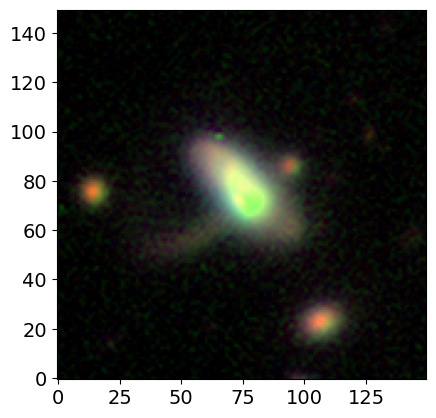

In [117]:
ek.imshow(
    make_lupton_rgb(bbmb.image['i'], bbmb.image['n708'], bbmb.image['r'], stretch=3, Q=5)
)